<DIV ALIGN=CENTER>

# Introduction to General Linear Models
## Professor Robert J. Brunner
  
</DIV>  
-----
-----

## Introduction

In this IPython Notebook, we introduce general linear models, which
provide a powerful approach for Bayesian model regression. One of the
main benefits of using a general linear model is a simplified approach
to computing a Bayesian model regression. However, the overall approach
enables general models that are linear in that each coefficient is
applied to a single variable or function of a single variable (which is
similar to general linear modeling). 

-----




In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----
### Model and Test Data

We reuse the model interface introduced in the Hierarchical Modeling
notebook. However, in this notebook, we have one data set since we are
fitting the entire data, as opposed to subsets of the data. Also, this
model now introduces an optional quadratic term, which will enable more
complex linear models to be compared.


-----

In [2]:
# Some common definitions
n_samples = 10000
n_burn = int(n_samples / 2)

# We define a simple function to fit.

np.random.seed(23)

# A non-linear equation
def theModel(x, params = None):

    # Default values
    beta = 0.5
    alpha = 0.25
    gamma = 0.2

    if params:
        alpha = params['Intercept']
        beta = params['x']
        gamma = params['np.power(x, 2)']

    return (alpha + beta * x  + gamma * x **2)

# Add random noise to model
def randomizeModel(xmin=0, xmax = 1, num=20):
    
    sigma = 0.1
    
    x = np.linspace(xmin, xmax, num)   
    y = theModel(x) + sigma * np.random.randn(len(x))

    return(x, y)

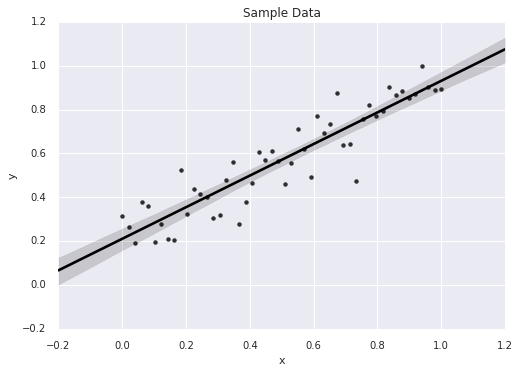

In [3]:
# Obtain sample data and plot data and model fit

x, y = randomizeModel(num = 50)

df = pd.DataFrame({'x': x, 'y': y})

ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=True, color='black', label="Data")
ax.set(title='Sample Data')
sns.despine(offset=5, trim=True)

-----

## General Linear Model

To fit a general linear model, we simply specify the functional form of
our model. The technique makes reasonable assumptions for the prior
distributions, and assumes a MAP starting point and NUTS sampler. As a
result, the fitting procedure is greatly simplified. In this example, we
fit a linear model (slope plus intercept) to the test data. As was the
case with the statsmodel library, we can use _R_ styled formulas.

-----

In [4]:
import pymc3 as pm

with pm.Model() as model_glm:
    pm.glm.glm('y ~ x', df)
    trace = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 6.2543: 100%|██████████| 200000/200000 [00:16<00:00, 12325.37it/s]
Finished [100%]: Average ELBO = 6.2398
100%|██████████| 10000/10000 [00:12<00:00, 813.28it/s]


-----
### Analyze Results

As before, we can analyze the trace results (either with or without
burn-in samples removed, in this example we have not removed the burn-in
samples). Below we display the summary statistics for the intercept and
slope model parameters (note that the slope is simply called `x` as
defined in our model. We also visualize the traces, both the
distribution of traces and their kernel density estimation.

-----

In [5]:
pm.summary(trace, ['Intercept', 'x'])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.211            0.027            0.001            [0.157, 0.261]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.158          0.193          0.211          0.229          0.263


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.719            0.046            0.001            [0.632, 0.810]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.633          0.688          0.719          0.750          0.811



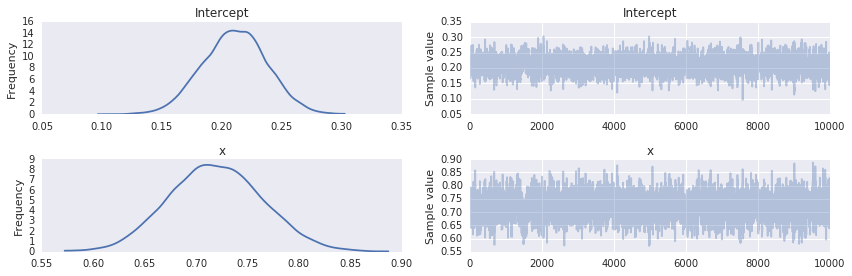

In [6]:
pm.traceplot(trace, ['Intercept', 'x'])
plt.show()

-----
### Visualize Results

We can plot the data, the true regression, the final model regression,
along with individual trace regressions in order to compare the
performance of this technique. The trace regressions can be easily
displayed by using the helper function `glm.plot_posterior_predictive`.
One of the benefits of this approach is the demonstration of different
traces sampling the likelihood space (and in some cases being wildly
off), before settling down to the _expected_ values.

-----

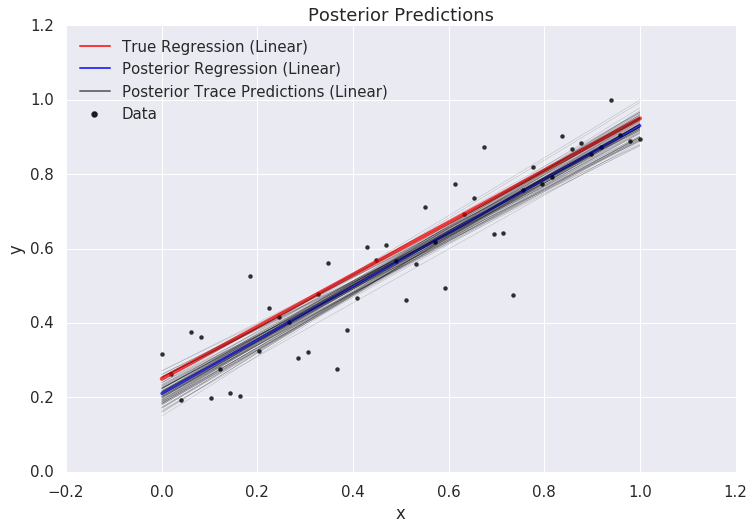

In [7]:
# Set up plot
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.5)

# plot the data
ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=False, color='black', label="Data")

# Compute and plot the true relationship
x_sample = np.linspace(0.0, 1.0, 2)
y_sample = theModel(x_sample)
plt.plot(x_sample, y_sample, color='r', lw=4, alpha = 0.75, \
         label='True Regression (Linear)')

# Define the mean posterior parameters
params = {}
params['Intercept'] = np.mean(trace['Intercept'][-n_burn:]) 
params['x'] = np.mean(trace['x'][-n_burn:])
params['np.power(x, 2)'] = 0.0

# Compute and plot the mean posterior prediction
y_est = theModel(x_sample, params)
plt.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75, \
         label='Posterior Regression (Linear)')

# Plot individual posterior predictions
pm.glm.plot_posterior_predictive(trace, samples=100, eval = x_sample, alpha=0.5,
                              label='Posterior Trace Predictions (Linear)')

# Decorate plot
plt.title('Posterior Predictions')
lgnd = plt.legend(loc='upper left')

for lg in lgnd.legendHandles:
    lg.set_linewidth(2.0)
    
plt.xlabel('x')
plt.ylabel('y')

sns.despine(offset=5, trim=True)
sns.set(font_scale=1)
plt.show()

-----

### Non-Linear Modeling

We can easily modify our model to capture non-linearities (despite the
name of the approach, we only require that products of terms are not
allowed, i.e., `x * cos(x)`). In this case, we fit a second order
polynomial, with the caveat that the patsy library that interprets our
functional forms does not understand the typical power operator. As a
result, we must employ the (somewhat bulky) numpy power operator.
Otherwise, the modeling approach remains the same.

-----

In [8]:
# Patsy doesn't recognize Python power operator **, so we use np.power.

with pm.Model() as model_glm2:
    pm.glm.glm('y ~ x + np.power(x, 2)', df)
    trace = pm.sample(n_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -10.658: 100%|██████████| 200000/200000 [00:19<00:00, 10453.34it/s]
Finished [100%]: Average ELBO = -10.652
100%|██████████| 10000/10000 [00:29<00:00, 333.39it/s]


-----
### Analyze Results

We can display the summary statistics for the traces as well as
visualize the traces and their kernel density estimates. In doing so, we
see one challenge of including the quadratic term is the lengthy name
for the coefficient of the quadratic term, which is simply taken from
the corresponding term in the formula supplied to the general linear
model (`np.power(x, 2)`).

-----

In [9]:
pm.summary(trace, ['Intercept', 'x', 'np.power(x, 2)'])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.237            0.040            0.001            [0.159, 0.316]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.159          0.212          0.238          0.263          0.316


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.556            0.189            0.006            [0.173, 0.925]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.174          0.436          0.556          0.678          0.927


np.power(x, 2):

  Mean             SD               MC Error         95% HPD interval
  ----------------

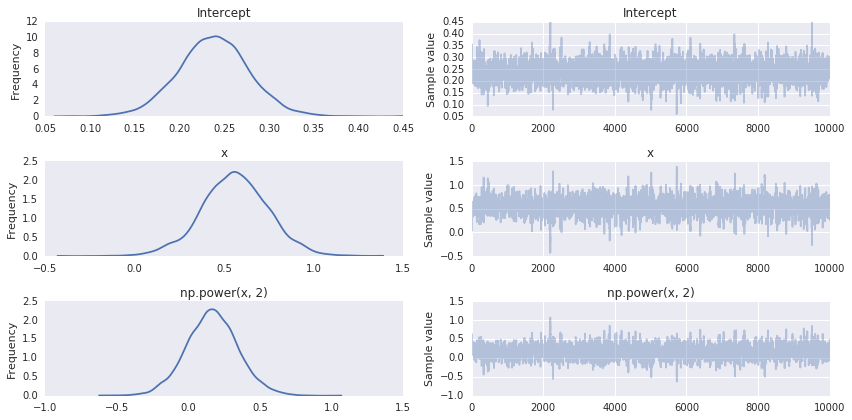

In [10]:
pm.traceplot(trace, ['Intercept', 'x', 'np.power(x, 2)'])
plt.show()

-----

### Visualize Results

We can visualize the model fit and the procedure used to generate the
fit as before. In this case, we supply the slope, intercept, and the
quadratic term to the model function either from the original model or
from the general linear modeling procedure. In this case, both the
individual traces and the overall regression results capture the true
relationship.

-----

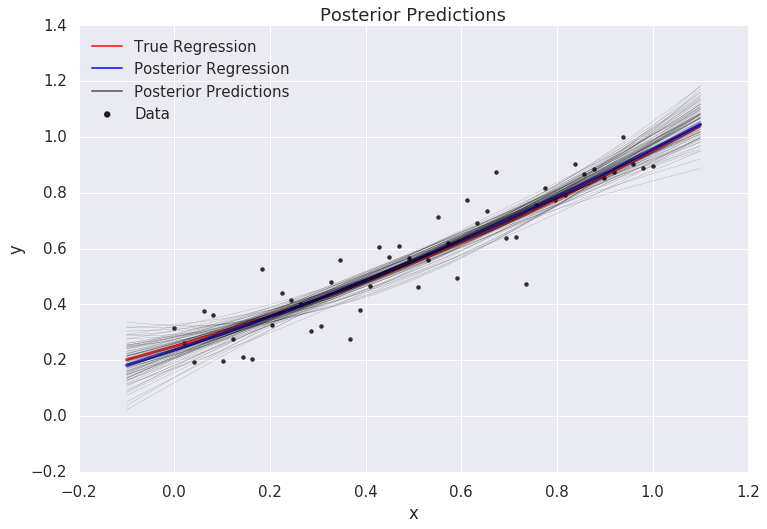

In [11]:
# Set up plot
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.5)

# plot the data
ax = sns.regplot(data = df, x = 'x', y = 'y', \
                 fit_reg=False, color='black', label="Data")

# Compute and plot the true relationship
x_sample = np.linspace(-0.1, 1.1, 100)
y_sample = theModel(x_sample)
plt.plot(x_sample, y_sample, color='r', lw=3, alpha = 0.75, \
         label='True Regression')

# Define the mean posterior parameters
params = {}
params['Intercept'] = np.mean(trace['Intercept'][-n_burn:]) 
params['x'] = np.mean(trace['x'][-n_burn:])
params['np.power(x, 2)'] = np.mean(trace['np.power(x, 2)'][-n_burn:])

# Compute and plot the mean posterior prediction
y_est = theModel(x_sample, params)
plt.plot(x_sample, y_est, color='b', lw=3, alpha = 0.75, \
         label='Posterior Regression')

# Plot individual posterior predictions
pm.glm.plot_posterior_predictive(trace, samples=100, \
                                 eval = x_sample, lm = theModel, \
                                 alpha=0.5, label='Posterior Predictions')

# Decorate plot
plt.title('Posterior Predictions')
lgnd = plt.legend(loc='upper left')

for lg in lgnd.legendHandles:
    lg.set_linewidth(2.0)
    
plt.xlabel('x')
plt.ylabel('y')

sns.despine(offset=5, trim=True)
sns.set(font_scale=1)
plt.show()

-----

### Student Activity

In the preceding cells, we introduced general liner models by using
pymc3. Now that you have run the Notebook, go back and make the
following changes to see how the results change.

1. Change the number of sample points both up and down, how does the glm
fit change?
2. Replace the existing model by a higher order model (include third and
possibly higher order terms). How well does the corresponding GLM fit
the data?
3. One can use the Bayes factor to compare model fits (simply the ratio
of the posteriors of the two models). Compute the Bayes factor for the
linear and quadratic model fits to the original data.

-----